# Your Mission, should you choose to accept it...

To hyperparameter tune and extract every ounce of accuracy out of this telecom customer churn dataset: <https://drive.google.com/file/d/1dfbAsM9DwA7tYhInyflIpZnYs7VT-0AQ/view> 

## Requirements

- Load the data
- Clean the data if necessary (it will be)
- Create and fit a baseline Keras MLP model to the data.
- Hyperparameter tune (at least) the following parameters:
 - batch_size
 - training epochs
 - optimizer
 - learning rate (if applicable to optimizer)
 - momentum (if applicable to optimizer)
 - activation functions
 - network weight initialization
 - dropout regularization
 - number of neurons in the hidden layer
 
 You must use Grid Search and Cross Validation for your initial pass of the above hyperparameters
 
 Try and get the maximum accuracy possible out of this data! You'll save big telecoms millions! Doesn't that sound great?


In [71]:
import pandas as pd
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Keras imports
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
# sklearn imports
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import numpy as np

np.random.seed(42)

pd.set_option('display.max_columns', 100)

df = pd.read_csv('../module3-Intro-to-Keras/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [50]:
df.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


In [64]:
df['Churn'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: Churn, dtype: float64

In [51]:
df['Churn'] = df['Churn'].replace({'No': 0, 'Yes': 1})
df['TotalCharges'] = df['TotalCharges'].replace({' ': 0})

#convert numeric cols to floats and normalize:
num_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols].values)

#1-hot encode categorical features:
cat_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',    
            'TechSupport', 'StreamingTV',    'StreamingMovies', 'Contract',
            'PaperlessBilling',    'PaymentMethod']
            
ce_onehot = ce.OneHotEncoder(cols=cat_cols, use_cat_names=True)
one_hot = ce_onehot.fit_transform(df[cat_cols])

#drop original cols from df and merge w/ one hot encoded:
df = df.drop(columns=cat_cols)  
df = pd.concat([df, one_hot], axis=1)

df.head()

/Users/lambda_school_loaner_95/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,customerID,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_Yes,Partner_No,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_No,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_Yes,OnlineSecurity_No internet service,OnlineBackup_Yes,OnlineBackup_No,OnlineBackup_No internet service,DeviceProtection_No,DeviceProtection_Yes,DeviceProtection_No internet service,TechSupport_No,TechSupport_Yes,TechSupport_No internet service,StreamingTV_No,StreamingTV_Yes,StreamingTV_No internet service,StreamingMovies_No,StreamingMovies_Yes,StreamingMovies_No internet service,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaperlessBilling_No,PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic)
0,7590-VHVEG,0.0,0.013889,0.115423,0.003437,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0
1,5575-GNVDE,0.0,0.472222,0.385075,0.217564,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0
2,3668-QPYBK,0.0,0.027778,0.354229,0.012453,1,0,1,0,1,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
3,7795-CFOCW,0.0,0.625000,0.239303,0.211951,0,0,1,0,1,1,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0
4,9237-HQITU,0.0,0.027778,0.521891,0.017462,1,1,0,0,1,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0


In [52]:
df.shape

(7043, 47)

In [55]:
X = df.drop(columns=['Churn', 'customerID'])
y = df['Churn']

In [56]:
X = X.values
y = y.values

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

In [76]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5282, 45), (5282,), (1761, 45), (1761,))

In [79]:
# Create Model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(45,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Fit Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=40)

Train on 5282 samples, validate on 1761 samples
Epoch 1/20
5282/5282 [==============================] - 2s 312us/step - loss: 0.4504 - acc: 0.7785 - val_loss: 0.4306 - val_acc: 0.7916
Epoch 2/20
5282/5282 [==============================] - 0s 74us/step - loss: 0.4188 - acc: 0.8014 - val_loss: 0.4320 - val_acc: 0.7910
Epoch 3/20
5282/5282 [==============================] - 0s 77us/step - loss: 0.4150 - acc: 0.8044 - val_loss: 0.4319 - val_acc: 0.7933
Epoch 4/20
5282/5282 [==============================] - 0s 80us/step - loss: 0.4088 - acc: 0.8067 - val_loss: 0.4329 - val_acc: 0.7893
Epoch 5/20
5282/5282 [==============================] - 0s 76us/step - loss: 0.4128 - acc: 0.8027 - val_loss: 0.4304 - val_acc: 0.7905
Epoch 6/20
5282/5282 [==============================] - 0s 74us/step - loss: 0.4065 - acc: 0.8078 - val_loss: 0.4298 - val_acc: 0.7893
Epoch 7/20
5282/5282 [==============================] - 0s 73us/step - loss: 0.4022 - acc: 0.8101 - val_loss: 0.4341 - val_acc: 0.7927
Epoch 

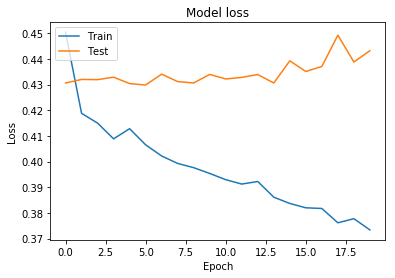

In [80]:
# plot loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Stretch Goals:

- Try to implement Random Search Hyperparameter Tuning on this dataset
- Try to implement Bayesian Optimiation tuning on this dataset
- Practice hyperparameter tuning other datasets that we have looked at. How high can you get MNIST? Above 99%?
- Study for the Sprint Challenge
 - Can you implement both perceptron and MLP models from scratch with forward and backpropagation?
 - Can you implement both perceptron and MLP models in keras and tune their hyperparameters with cross validation?